## **Laboratorio: Redes Neuronales Recurrentes (RNN) para Generación de Texto**



**¿Qué son las Redes Neuronales Recurrentes (RNNs)?**

Las Redes Neuronales Recurrentes (RNNs) son una clase de redes neuronales diseñadas para procesar secuencias de datos. A diferencia de las redes neuronales tradicionales, las RNNs tienen conexiones recurrentes que les permiten mantener una "memoria" de estados anteriores, lo que las hace especialmente útiles para tareas como procesamiento de lenguaje natural, reconocimiento de voz y generación de texto.

**Objetivo del Ejercicio**
Implementar y entrenar una Char-RNN en PyTorch para generar texto similar al de Shakespeare. A lo largo del ejercicio, se realizará lo siguiente:

* Construcción de una Char-RNN: Definir una arquitectura RNN básica para la generación de texto.
* Preparación de Datos: Procesar y convertir texto en tensores que pueden ser utilizados por la RNN.
* Entrenamiento del Modelo: Implementar el ciclo de entrenamiento para ajustar los pesos de la RNN.
* Generación de Texto: Utilizar el modelo entrenado para generar nuevas secuencias de texto.
* Visualización y Evaluación: Monitorear la pérdida y la perplejidad durante el entrenamiento para evaluar el desempeño del modelo.

In [ ]:
# Instalación de la librería necesaria
# Comenta la siguiente línea si ya tienes instalada la librería unidecode
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.7 MB/s eta 0:00:00


**Celda 1: Instalación e Importación de Librerías**

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import unidecode
import string
import random
import time
import math
import os
import argparse
import matplotlib.pyplot as plt
from tqdm import tqdm
from unidecode import unidecode
from google.colab import auth
from google.colab import drive
import io
import requests



Explicación: En esta celda, instalamos e importamos todas las librerías necesarias para nuestro proyecto.

*   unidecode se utiliza para convertir caracteres Unicode a ASCII
*   torch es la librería principal para construir y entrenar nuestro modelo de red neuronal
* matplotlib y tqdm son utilizadas para la visualización y el seguimiento del progreso del entrenamiento


**Celda 2: Definición de Caracteres y Lectura del Archivo**

In [ ]:
# Definir todos los caracteres posibles
all_characters = string.printable
n_characters = len(all_characters)

# Función modificada para leer desde Google Drive
def read_file(file_id):
    # URL base para acceder a archivos de Google Drive
    url = f'https://drive.google.com/uc?id={file_id}'

    # Realizar la petición GET al archivo
    response = requests.get(url)
    if response.status_code == 200:
        # Leer el contenido como texto
        text = response.content.decode('utf-8')
        # Convertir a ASCII
        text = unidecode(text)
        return text, len(text)
    else:
        raise Exception(f"Error al leer el archivo: {response.status_code}")

# Convertir una cadena de caracteres a tensor de índices
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue  # Ignorar caracteres no encontrados
    return tensor

# Formatear el tiempo transcurrido
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s:.0f}s'

# Extraer el ID del archivo de la URL completa
def get_file_id_from_url(url):
    # Buscar el ID en la URL de Google Drive
    if '/file/d/' in url:
        file_id = url.split('/file/d/')[1].split('/')[0]
        return file_id
    return None

# Leer los datos
#drive_url = "https://drive.google.com/file/d/16eZEJJ__auJ-HKK993BiZpLg5vyu_t3A/view?usp=sharing" #Obras shakespeare
drive_url = "https://drive.google.com/file/d/1slvHVcRqNfw33ieqBsPbZ-Qh-_EgmC_P/view?usp=sharing" #Guiones Capítulos La Que se Avecina
file_id = get_file_id_from_url(drive_url)
file, file_len = read_file(file_id)
print(f'Número de caracteres en el archivo: {file_len}')

Número de caracteres en el archivo: 291714


Explicación:



*   Caracteres Definidos: Utilizamos string.printable para definir todos los caracteres que nuestro modelo reconocerá.
*   Lectura del Archivo: La función read_file lee el contenido del archivo de texto y lo convierte a ASCII para evitar problemas con caracteres especiales.
* Conversión a Tensor: char_tensor convierte una cadena de texto en un tensor de índices, donde cada carácter se reemplaza por su posición en all_characters.
* Formateo de Tiempo: time_since es una función auxiliar para formatear el tiempo transcurrido durante el entrenamiento.








**Celda 3: Definición del Modelo CharRNN (Simplificado)**

In [ ]:
# Definición del Modelo CharRNN
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        # Capa de embedding para convertir índices en vectores densos
        self.encoder = nn.Embedding(input_size, hidden_size)

        # Capa GRU o LSTM
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)

        # Capa lineal para predecir el siguiente carácter
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        # Pasar el input por la capa de embedding
        encoded = self.encoder(input)

        # Pasar el embedding a través de la RNN
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)

        # Pasar la salida de la RNN a través de la capa lineal
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))


Explicación:

* Capa de Embedding (self.encoder): Convierte los índices de caracteres en vectores densos que la RNN puede procesar.
* Capa RNN (self.rnn): Puede ser una GRU o una LSTM según el parámetro model. Estas capas manejan dependencias a lo largo de la secuencia.
* Capa Lineal (self.decoder): Mapea la salida de la RNN al espacio de salida correspondiente al número de caracteres.

Métodos:

* forward: Define cómo pasan los datos a través del modelo durante el entrenamiento y la generación.
* init_hidden: Inicializa el estado oculto de la RNN. Para LSTM, devuelve una tupla con los estados oculto y de celda; para GRU, solo el estado oculto.

**Celda 4: Preparación del Conjunto de Entrenamiento**

In [ ]:
# Función para crear un conjunto de entrenamiento aleatorio
def random_training_set(chunk_len, batch_size, file, file_len, cuda=False):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    if cuda:
        inp = inp.cuda()
        target = target.cuda()
    return inp, target


Explicación: Esta función genera lotes de entrenamiento aleatorios extrayendo secuencias de caracteres del texto. Cada secuencia de entrada (inp) está desplazada por un carácter con respecto a la secuencia objetivo (target), lo que permite al modelo aprender a predecir el siguiente carácter.

**Celda 5: Definición de la Función de Entrenamiento**

In [ ]:
# Función de entrenamiento
def train(inp, target, decoder, criterion, decoder_optimizer, chunk_len, batch_size, cuda=False):
    hidden = decoder.init_hidden(batch_size)
    if cuda:
        hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:, c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:, c])

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len


Explicación: Esta función realiza una pasada de entrenamiento sobre un lote de datos:

* Inicializa el estado oculto: hidden = decoder.init_hidden(batch_size)
* Limpia los gradientes acumulados: decoder.zero_grad()
* Calcula la pérdida: Suma las pérdidas de cada carácter en la secuencia.
* Retropropagación y Optimización: Calcula los gradientes (loss.backward()) y actualiza los pesos del modelo (decoder_optimizer.step()).
* Finalmente, retorna la pérdida promedio por carácter para el lote actual.

Celda 6: Configuración del Modelo y Parámetros de Entrenamiento

In [ ]:
# Parámetros del modelo y entrenamiento
#filename = "/content/shakespeare.txt"  # Ya lo hemos definido en la celda 2
n_epochs = 2000
model_type = "gru"  # Puede ser "gru" o "lstm"
print_every = 100
hidden_size = 100
n_layers = 2
learning_rate = 0.01
chunk_len = 200
batch_size = 100
cuda_flag = False  # Cambiar a True si se desea usar GPU

# Leer los datos
file, file_len = read_file(filename)

# Inicializar el modelo, optimizador y función de pérdida
decoder = CharRNN(n_characters, hidden_size, n_characters, model=model_type, n_layers=n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

if cuda_flag:
    decoder.cuda()


Explicación: En esta celda, definimos los parámetros para el modelo y el entrenamiento, inicializamos el modelo CharRNN, el optimizador Adam y la función de pérdida CrossEntropyLoss. También configuramos la opción para usar GPU si está disponible (cuda_flag = True).

**Celda 7: Bucle de Entrenamiento**

In [ ]:
# Función para guardar el modelo
def save(decoder, filename):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(decoder, save_filename)
    print(f'Saved as {save_filename}')

# Función para generar texto
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str

    # "Calentar" la RNN con la cadena inicial
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:, p], hidden)

    inp = prime_input[:, -1]

    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)

        # Transformar la salida en una distribución de probabilidad
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Convertir el índice a carácter y añadirlo a la predicción
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted

# Iniciar el entrenamiento
start = time.time()
all_losses = []
perplexities = []

try:
    print(f"Training for {n_epochs} epochs...")
    for epoch in tqdm(range(1, n_epochs + 1)):
        inp, target = random_training_set(chunk_len, batch_size, file, file_len, cuda=cuda_flag)
        loss = train(inp, target, decoder, criterion, decoder_optimizer, chunk_len, batch_size, cuda=cuda_flag)
        all_losses.append(loss)
        perplexities.append(math.exp(loss))

        if epoch % print_every == 0:
            print(f'[{time_since(start)}] ({epoch} / {n_epochs}) Loss: {loss:.4f}')
            # Generar texto de ejemplo
            print(generate(decoder, 'Wh', 100, temperature=0.8, cuda=cuda_flag))
            print('-----------------------------------')

    print("Saving...")
    save(decoder, filename)

except KeyboardInterrupt:
    print("Saving before quit...")
    save(decoder, filename)


Training for 2000 epochs...


  5%|▌         | 100/2000 [01:46<29:04,  1.09it/s]

 46s] (100 / 2000) Loss: 1.4779
Wh de miris de michar que emprefebarle con los ambien.
RECIO: (Sonriendo) !Dampuen quitan) !Gracias a 
-----------------------------------


 10%|█         | 200/2000 [03:22<28:36,  1.05it/s]

 22s] (200 / 2000) Loss: 1.1993
Who, esta la penseguira mas metales.
LEO: !No es una vez! Esi es. Asi es un hermanio para poquir y el 
-----------------------------------


 15%|█▌        | 300/2000 [04:58<30:43,  1.08s/it]

 59s] (300 / 2000) Loss: 1.0161
Whames.

ENRIQUE: (Asoleta) Bueno, que todo esta on tiempo.

VICENTE: (Bromeando) Y yo puedo sergiente
-----------------------------------


 20%|██        | 400/2000 [06:33<24:05,  1.11it/s]

 33s] (400 / 2000) Loss: 0.9894
Whamos para la cena y la comunidad y la olgunidad.

BERTA: (Agradecida) Si, siempre te esta fuer ascut
-----------------------------------


 25%|██▌       | 500/2000 [08:11<23:25,  1.07it/s]

 11s] (500 / 2000) Loss: 0.9535
Whar todo que nos en suelto. ?La calta que todos luces que nos fundienes algunos estan en
onriente de 
-----------------------------------


 30%|███       | 600/2000 [09:47<25:47,  1.11s/it]

 47s] (600 / 2000) Loss: 0.9214
Whada para los pescadero para asegurarnos mas problemas.

RAQUEL: (Sonriendo) Si, lo ha estare algunas
-----------------------------------


 35%|███▌      | 700/2000 [11:21<19:59,  1.08it/s]

 22s] (700 / 2000) Loss: 0.7847
Whamados un coches y fortalecer nosotros por todas participaremos.

BERTA: (Sonriendo) Trego, estoy co
-----------------------------------


 40%|████      | 800/2000 [12:56<20:09,  1.01s/it]

 57s] (800 / 2000) Loss: 0.8582
Whametamos muchos mas gracias de todos, Amador!

AMADOR: (Sonriendo) Y mientras una excelente venea in
-----------------------------------


 45%|████▌     | 900/2000 [14:33<18:17,  1.00it/s]

 33s] (900 / 2000) Loss: 0.8040
Whamateia que un forcinos)) !Proco! !Eso es mue erfresico, te has herros esta organizacion esperanzand
-----------------------------------


 50%|█████     | 1000/2000 [16:09<15:24,  1.08it/s]

 9s] (1000 / 2000) Loss: 0.7627
Whamor mas contento, Betando un accion quimitado a todos por la organizar una reunion.

MAITE: (Sonrie
-----------------------------------


 55%|█████▌    | 1100/2000 [17:47<20:42,  1.38s/it]

 48s] (1100 / 2000) Loss: 0.7586
Whas video unida, bundo) !Perfecto! Y yo vamos a organizar unas gambas con la comunidad. A que estoy i
-----------------------------------


 60%|██████    | 1200/2000 [19:25<14:49,  1.11s/it]

 25s] (1200 / 2000) Loss: 0.7631
Who, Antonio, para que todos espedide de cada interesa. ?Serio ya sabia que todo este listo.

COQUE: (
-----------------------------------


 65%|██████▌   | 1300/2000 [21:00<10:37,  1.10it/s]

 1s] (1300 / 2000) Loss: 0.7769
Whore mis callado con la la estresando, sucar lo va a abrir la peliterios.
ANTONIO RECCIO: !Esto es !o
-----------------------------------


 70%|███████   | 1400/2000 [22:36<09:40,  1.03it/s]

 36s] (1400 / 2000) Loss: 0.7232
Whora quieado para la comunidad.

JAVI: (Con entusiasmo) !Vamos a bainar! No sera una vida?

JAVI: (Ri
-----------------------------------


 75%|███████▌  | 1500/2000 [24:11<08:01,  1.04it/s]

 12s] (1500 / 2000) Loss: 0.7274
Who el participarle los encontrarle un torneo de pinchos cuenta.

ANTONIO: (Sonriendo) Bueno, que es m
-----------------------------------


 80%|████████  | 1600/2000 [25:48<06:27,  1.03it/s]

 48s] (1600 / 2000) Loss: 0.7372
Whos folleccion y poco de tu pusos podemos las ciguenas, Vicente. Siempre que siempre es pagaba.

COQU
-----------------------------------


 85%|████████▌ | 1700/2000 [27:24<04:58,  1.00it/s]

 24s] (1700 / 2000) Loss: 0.7804
Whogoramos.

ENRIQUE: (Riendo) Si, esto es Bremor. A veces seriezo este encontraron razor.

NINES: (En
-----------------------------------


 90%|█████████ | 1800/2000 [28:58<03:02,  1.10it/s]

 59s] (1800 / 2000) Loss: 0.7153
Whorazora, mentador a nuestra comunidad para el torneo de pinchos.

AMADOR: (Sonriendo) !Adelante! Est
-----------------------------------


 95%|█████████▌| 1900/2000 [30:34<01:35,  1.05it/s]

 35s] (1900 / 2000) Loss: 0.7125
Whores no consmigal posible.

ANTONIO: (Sonriendo) Bueno, pues de una buena obor.

JUDITH: (Sonriendo)
-----------------------------------


100%|██████████| 2000/2000 [32:10<00:00,  1.04it/s]

 10s] (2000 / 2000) Loss: 0.7201
Whores. Ya entiendose a la ormanidad.

COQUE: (Con una sonrisa) Claro, ?que tengo mas.

ANTONIO: (Revi
-----------------------------------
Saving...
Saved as lqsa.pt


Explicación: Este es el bucle principal de entrenamiento donde el modelo se entrena durante múltiples épocas:

* Generación de Lotes de Entrenamiento: inp, target = random_training_set(...)
Entrenamiento: loss = train(...)
* Registro de la Pérdida y Perplejidad: Almacenamos la pérdida y calculamos la perplejidad (math.exp(loss)).
* Monitoreo del Progreso: Cada print_every épocas, imprimimos la pérdida actual y generamos una muestra de texto para observar el progreso del modelo.
* Guardado del Modelo: Al finalizar el entrenamiento o si se interrumpe manualmente, guardamos el modelo entrenado usando la función save.

Funciones Incluidas:

* save: Guarda el modelo entrenado en un archivo .pt para poder usarlo en un futuro.
* generate: Genera texto basado en una cadena inicial (prime_str). Controla la aleatoriedad de la generación mediante la temperatura.

## **¿Qué es la Perplejidad?**

La **perplejidad** es una métrica utilizada para evaluar la calidad de los modelos de lenguaje, como las Redes Neuronales Recurrentes (RNNs). En términos simples, la perplejidad mide cuán bien el modelo predice una muestra de texto.

### **¿Cómo se Calcula?**

Matemáticamente, la perplejidad se define como la exponencial de la entropía cruzada del modelo. Específicamente:

\[
\text{Perplejidad} = e^{\text{Entropía cruzada}}
\]

En nuestro modelo, calculamos la perplejidad a partir de la pérdida (loss) obtenida durante el entrenamiento.

### **¿Cómo Interpretar la Perplejidad?**

- **Valores Bajos:** Indican que el modelo está haciendo buenas predicciones sobre los datos de entrenamiento, es decir, el modelo es menos "perplejo" ante los datos que está viendo.
  
- **Valores Altos:** Sugieren que el modelo tiene dificultades para predecir los caracteres siguientes en el texto, lo que puede significar que el modelo no ha aprendido bien los patrones del lenguaje en los datos de entrenamiento.

### **Uso de la Perplejidad en el Entrenamiento**

Durante el entrenamiento, monitorizamos la perplejidad para evaluar el progreso del modelo. Una disminución constante en la perplejidad generalmente indica que el modelo está aprendiendo a predecir mejor los caracteres siguientes en las secuencias de texto.


**Celda 8: Visualización de la Perplejidad**

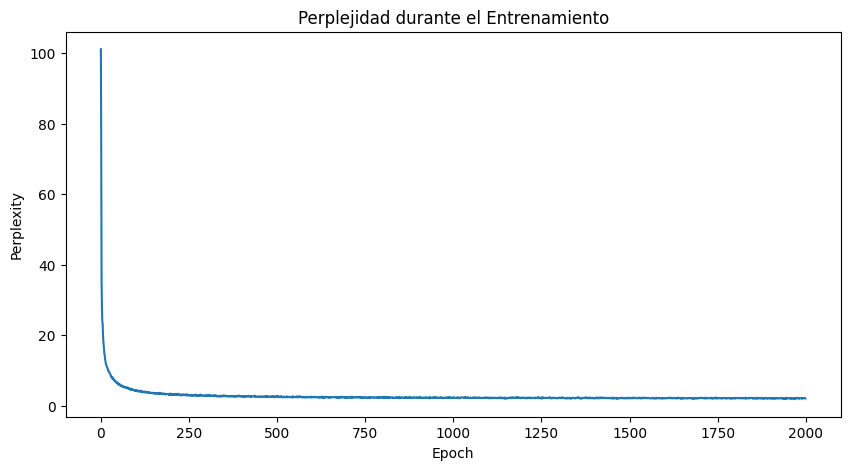

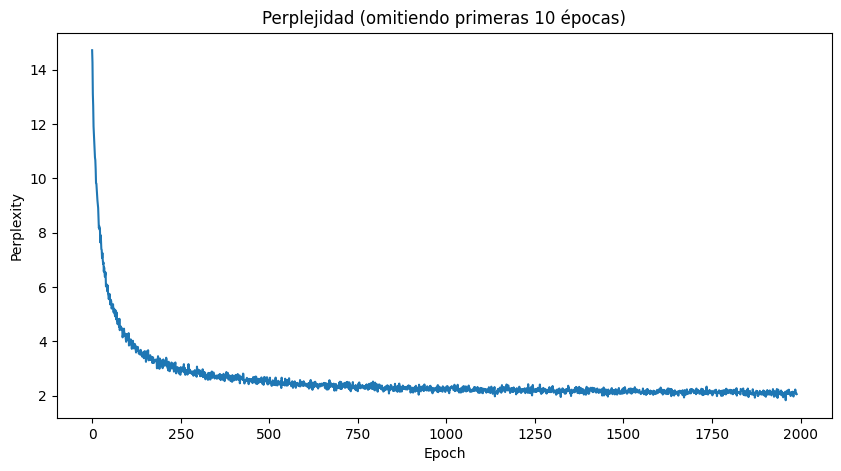

In [ ]:
# Graficar la perplejidad
plt.figure(figsize=(10,5))
plt.plot(perplexities)
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.title('Perplejidad durante el Entrenamiento')
plt.show()

# Graficar la perplejidad omitiendo las primeras 10 épocas para mayor claridad
plt.figure(figsize=(10,5))
plt.plot(perplexities[10:])
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.title('Perplejidad (omitiendo primeras 10 épocas)')
plt.show()


Explicación: En esta celda, graficamos la perplejidad del modelo a lo largo de las épocas de entrenamiento. La perplejidad es una medida que indica qué tan bien el modelo está prediciendo el texto; valores más bajos son mejores. Además, graficamos la perplejidad omitiendo las primeras 10 épocas para una visualización más clara, ya que al inicio la perplejidad puede ser muy alta.

**Celda 9: Generación de Texto con Cadenas Aleatorias y Específicas**

In [ ]:
# Funciones para generar texto con cadenas aleatorias
def randomString(length):
    return ''.join(random.choice(string.printable) for _ in range(length))

# Cargar el modelo guardado
decoder = torch.load("lqsa.pt")

# Generar texto con cadenas aleatorias
for i in range(5):
    prime_string = randomString(5)
    print(f"======Prime string: {prime_string} ======")
    print(generate(decoder, prime_str=prime_string, predict_len=100, temperature=0.8, cuda=cuda_flag))
    print('-----------------------------------')

# Generar texto con cadenas específicas
priming_sequences = [
    "RECIO:",
    "Cuqui ",
    "el pescador",
    "X087hNYB BHN BYFVuhsdbs"
]

for prime in priming_sequences:
    print(f"Prime string: {prime}")
    print(generate(decoder, prime_str=prime, predict_len=100, temperature=0.8, cuda=cuda_flag))
    print('-----------------------------------')


<ipython-input-12-8385afec1bf0>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder = torch.load("lqsa.pt")


======Prime string: uH/
uH/
	ENRA: Ya lo hago de aplo relezas su jardin por mi consmos.

ANTONIO: O si nuevo sin a tenero al cine
-----------------------------------
======Prime string: +1LZ= ======
+1LZ= estamos asegurarnos de que todo sabente estan los vecinos.
AMADOR: Eso si toque viajo a ser que lle
-----------------------------------
======Prime string: j	)# ======
j	)# TIIO - TARDE NINTES !La!

EqETERA: De la que la de la subastal en casado y vecino se lo v oy a pael
-----------------------------------
======Prime string: K[u-! ======
K[u-! Vamos, Amador!

JUDITH: (Bromeando) Claro, Amador, no, y o sigue en el proyen de nudieron sin en un
-----------------------------------
======Prime string: q&KmZ ======
q&KmZuetate que el vica la cena se acuerda en inflamable.

ANTONIO: (Resignado) Esta bien manana, pero si
-----------------------------------
Prime string: RECIO:
RECIO: Me aleto para pagar la tiempo.
BERTA:Tu lleche y hacer quemas, les volver o vender a todos.

BERTA:
------

Explicación: Aquí generamos texto utilizando el modelo entrenado:

* Cadenas Aleatorias: Generamos cinco cadenas iniciales aleatorias de 5 caracteres y extendemos el texto a partir de ellas.
* Cadenas Específicas: Utilizamos cadenas iniciales específicas para observar cómo el modelo continúa diferentes contextos.


**Celda 10: Conclusión y Observaciones**

### **Resumen de lo Aprendido:**
1. **Construcción de una Char-RNN:**
   - Aprendimos a definir una arquitectura RNN básica utilizando **GRU** o **LSTM** para la generación de texto a nivel de carácter.
   
2. **Preparación y Procesamiento de Datos:**
   - Procesamos el texto de Shakespeare, lo convertimos a ASCII y lo transformamos en tensores de índices para ser utilizados por la RNN.
   
3. **Entrenamiento del Modelo:**
   - Implementamos el ciclo de entrenamiento, monitoreando la pérdida y la perplejidad para evaluar el progreso del modelo.
   
4. **Generación de Texto:**
   - Utilizamos el modelo entrenado para generar nuevas secuencias de texto basadas en cadenas iniciales aleatorias y específicas.
   
5. **Visualización de la Perplejidad:**
   - Graficamos la perplejidad durante el entrenamiento para entender cómo mejora el modelo con el tiempo.

### **Observaciones Importantes:**
- **Perplejidad como Métrica:** La perplejidad es una métrica útil para evaluar la capacidad del modelo para predecir el siguiente carácter en la secuencia. Una disminución constante en la perplejidad indica que el modelo está aprendiendo a generar texto más coherente.
  
- **Impacto de la Temperatura en la Generación de Texto:**
  - **Temperaturas Más Altas (e.g., 1.0):** Generan texto más variado y creativo, pero pueden ser menos coherentes.
  - **Temperaturas Más Bajas (e.g., 0.5):** Generan texto más predecible y coherente, pero menos variado.
  
- **Elección de la Arquitectura RNN:**
  - **GRU vs. LSTM:** Aunque ambos son efectivos para manejar dependencias a largo plazo, las **LSTM** tienden a ser más poderosas pero también más complejas, mientras que las **GRU** son más simples y requieren menos recursos computacionales.

### **Próximos Pasos:**
- **Experimentar con Diferentes Arquitecturas:** Probar con **LSTM** en lugar de **GRU** y comparar los resultados.
- **Ajustar Hiperparámetros:** Experimentar con diferentes tasas de aprendizaje, tamaños de lote, y dimensiones de la capa oculta para optimizar el rendimiento del modelo.
- **Implementar Técnicas de Regularización:** Añadir **Dropout** para prevenir el sobreajuste y mejorar la generalización del modelo.
- **Extender la Longitud de Generación:** Generar textos más largos para evaluar la coherencia a mayor escala.
- **Explorar Modelos Más Avanzados:** Investigar modelos de generación de texto más avanzados como **Transformers** para mejorar la calidad y coherencia del texto generado.

### **Recursos Adicionales:**
Para profundizar más en el entrenamiento y la optimización de RNNs, te recomiendo revisar los siguientes recursos:
- **Documentación de PyTorch:**
  - [Tutorial de RNN en PyTorch](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)
  
- **Video Tutorial:**
  - [Curso de PyTorch - RNNs y Generación de Texto](https://www.youtube.com/watch?v=8uR4Zv4K8HI)
  
- **Libros y Artículos:**
  - *Deep Learning* por Ian Goodfellow, Yoshua Bengio y Aaron Courville.

¡Felicidades por completar el ejercicio!
